# 一、前言
## 1.1 指数增强思路及实践方式
根据华泰证券金工研报《指数增强方法汇总及实例》中的论述，从宏观再到微观，指数增强思路可分为`仓位控制`、`行业轮动`、`选股`三个方面。该三方面在实践方式上又都可以统一区分成`“主动”`和`“量化”`两种，越靠近宏观层面主动与量化的差别越小，越靠近微观层面二者差别越大,目前主流公募指数增强产品以量化为主。

**仓位控制**：本质上为中长线择时，其目的是预判大盘走势，在上涨时调高仓位，在下跌时降低仓位，调整频率一般在月频至年频。大盘未来走势主要通过在宏观、政策、经济周期等层面进行分析来综合判断，但由于大盘的走势和宏观经济、微观企业、国家政策、国际形势等因素都密切相关，想要准确判断大盘走势难度很大。 

**行业轮动**：是利用行业间相对变化趋势从中获利，是介于宏观和微观视角之间的一个研究领域。在一个完整的经济周期中，既有先行行业，又有跟随行业，通过把握经济周期中的行业轮动顺序，在轮动开始前进行配置，在轮动结束后进行调整，可以获取超额收益，实现指数增强的目标。需注意的是，基于行业轮动进行资产配置需要控制投资组合相对基准的行业偏离度，从而达到控制跟踪误差的目的。

**选股**：量化选股模型的主流是多因子模型，还有 SmartBeta、基本面量化选股、事件驱动选股等模型，主动方法选股则主要依靠公司研究，选择被错误低估的股票，此外还可以借鉴期货管理策略中的配对交易应用于股票市场进行个股权重配置。根据选股范围的不同，可以分为在基准指数成份股内选股、在成份股以及部分指定股票中选股（例如在中证 800 成份股范围内选股进行沪深 300 指数增强）、在全部 A 股中选股等。三种方式的自由度依次提升，一般在基金合同中会规定采取哪种选股方式，采用全部 A 股
当作备选股票池的产品最多。实际上，由于基金公司内部常会有选股范围限制，所以在操作层面上采用第二种股票池的也比较多。

**本文就是基于该思想，站在微观视角，采用的`量化多因子指数增强策略`，相比主动方法，该策略的优势在于能科学控制跟踪误差，减少波动。**

此外，不论采用以上哪种操作思路，投资管理人都可以考虑配合衍生金融工具或一些其它方式进行增强，如通过打新或借助股指期货、融资融券、期权、可转债等工具进行增强。 
 
## 1.2 指数增强策略的目标
`目标`是在对基准指数跟踪的同时获得超额收益，即在控制跟踪误差的前提下获取增强收益，一般认为指数增强型基金的年化跟踪误差需控制在7.75%以内。跟踪误差是跟踪偏离度的标准差，其公式如下：

$$TD_{ti}=R_{ti}-R_{tb}$$

$$TE=\frac{1}{n-1}\sum_{t=1}^{n}\left [ TD_{ti} -\frac{1}{n}\left ( \sum_{t=1}^{n}TD_{ti} \right )\right ]^{2}$$

其中$TD_{ti}$为基金跟踪偏离度，是基金净值变化率（$R_{ti}$）与基金的业绩基准同期收益率（$R_{tb}$）之差。

## 1.3 本文主要内容  

本文先是构建了收益预测模型，通过打分法得到个股的预测收益率，再构建两个量化多因子指数增强策略，一个是`分层抽样策略`，该策略较为简单，只涉及市值和行业两个重要的风险因子，其核心就是使投资组合在两个风险维度上与基准指数保持一致，在市值、行业属性比较相似的若干只股票里优选一只预期收益最高的进行投资，从而获取超额收益；另一个是`多因子线性优化模型`，该策略较为复杂，其核心是控制投资组合在更多的风险因子上的暴露与基准指数一致，以期获得更小的跟踪误差，该策略一般需要通过求解二次优化或非线性优化问题来构建最优组合。            

本文参考：
+ 华泰证券《指数增强方法汇总及实例——量化多因子指数增强策略实证》
+ 天风证券《基于自适应风险控制的指数增强策略》

In [1]:
from jqdata import *
from jqfactor import (get_factor_values,
                      calc_factors,
                      Factor)

import talib
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.optimize import minimize
 
from tqdm import tqdm_notebook
from dateutil.parser import parse

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
plt.style.use('seaborn')

# 二、数据筛选

1. 回测区间:2014年01月01日至2020年09月30日;
2. 调仓日：每月最后一个交易日为调仓日，以每月最后一个交易日的收盘价买入卖出；
3. 股票池：HS300；剔除选股日的ST股票；剔除上市不满1年的股票；剔除选股日由于停牌等原因而无法买入的股票；
4. 所需因子如下表：

|类别|因子名称|因子code|因子计算方式|
|--|--|--|
|规模|对数市值|natural_log_of_market_cap|总市值取对数|
|估值|账面市值比|book_to_price_ratio|净资产/总市值|
|估值|市盈率倒数 TTM|EPTTM|归母净利润 TTM/总市值(Factor)|
|估值|市销率倒数 TTM|SPTTM|营业收入 TTM/总市值(Factor)|
|技术指标|一个月反转|ROC20|过去 20 个交易日涨跌幅|
|技术指标|三个月反转|ROC60|过去 60 个交易日涨跌幅|
|成长|净利润增长率|net_profit_growth_rate|(今年净利润（TTM）/去年净利润（TTM）)-1(修改)|
|成长|营业收入增长率|operating_revenue_growth_rate|今年营业收入（TTM）/去年营业收入（TTM））-1(修改)|
|成长|利润总额增长率|total_profit_growth_rate|(今年利润总额（TTM）/去年利润总额（TTM）)-1(修改)|
|成长|标准化预期外盈利|SUE|（单季度实际净利润-预期净利润）/预期净利润标准差(Factor)|
|成长|标准化预期外收入|SUR|（单季度实际营业收入-预期营业收入）/预期营业收入标准差(Factor)|
|盈利|单季度净资产收益率|roe_ttm|单季度归母净利润*2/（期初归母净资产+期末归母净资产)(修改)|
|盈利|单季度总资产收益率|roa_ttm|单季度息税前利润*2/（期初总资产+期末总资产）(修改)|
|盈利|单季度净资产收益率同比变化|DELTAROE|单季度净资产收益率-去年同期单季度净资产收益率(Factor)|
|盈利|单季度总资产收益率同比变化|DELTAROA|单季度总资产收益率-去年同期单季度中资产收益率(Factor)|
|流动性|非流动性冲击|ILLIQ|过去20个交易日涨幅绝对值/成交额均值(Factor)|
|流动性|一个月日均换手|VOL20|过去20个交易换手率均值|
|流动性|三个月日均换手|VOL60|过去60个交易换手率均值|
|波动|特异度|IVR|1-过去20交易日Fama-French三因子回归拟合度(Factor)|
|波动|一个月真实波动率|ATR1M|过去20个交易日日内真实波幅均值(Factor)|
|波动|三个月真实波动率|ATR3M|过去60个交易日日内真实波幅均值(Factor)|

*一致性预期、分红数据聚宽没有故模型中也缺失相应的因子*

因子计算方式Factor标记为使用Factor类构造的,修改标记为在原始模型上做的修改

## 1.1因子构造

部分因子无法直接使用聚宽的因子库获取故这里手动构造模型所需因子，此部分因子在上述模型所需的表中的因子计算方式项中标记有Factor

In [3]:
class EPTTM(Factor):
    
    name = 'EPTTM'
    max_window = 1
    dependencies = ['pe_ratio']
    
    def calc(self,data):
        
        return (1 / data['pe_ratio']).iloc[0]
    
class SPTTM(Factor):
    
    name = 'SPTTM'
    max_window = 1
    dependencies = ['ps_ratio']
    
    def calc(self,data):
        
        return (1 / data['ps_ratio']).iloc[0]
    

class SUE0(Factor):

    '''含漂移项'''

    name = 'SUE0'
    max_window = 1

    global fields

    fields = [f'net_profit_{i}' if i != 0 else 'net_profit' for i in range(9)]

    dependencies = fields

    def calc(self, data):

        # 数据结构为 columns为 net_profit至net_profit_8
        df = pd.concat([v.T for v in data.values()], axis=1)
        df.columns = fields
        df.fillna(0, inplace=True)

        # 漂移项可以根据过去两年盈利同比变化Q{i,t} - Q{i,t-4}的均值估计
        # 数据结构为array
        tmp = df.iloc[:, 1:5].values - df.iloc[:, 5:].values

        C = np.mean(tmp, axis=1)  # 漂移项 array

        epsilon = np.std(tmp, axis=1)  # 残差项epsilon array

        Q = df.iloc[:, 4] + C + epsilon  # 带漂移项的季节性随机游走模型

        return (df.iloc[:, 0] - Q) / epsilon
    
class SUR0(Factor):

    '''含漂移项'''

    name = 'SUR0'
    max_window = 1

    global fields

    fields = [f'operating_revenue_{i}' if i !=
              0 else 'operating_revenue' for i in range(9)]

    dependencies = fields

    def calc(self, data):

        # 数据结构为 columns为 net_profit至net_profit_8
        df = pd.concat([v.T for v in data.values()], axis=1)
        df.columns = fields
        df.fillna(0, inplace=True)

        # 漂移项可以根据过去两年盈利同比变化Q{i,t} - Q{i,t-4}的均值估计
        # 数据结构为array
        tmp = df.iloc[:, 1:5].values - df.iloc[:, 5:].values

        C = np.mean(tmp, axis=1)  # 漂移项 array

        epsilon = np.std(tmp, axis=1)  # 残差项epsilon array

        Q = df.iloc[:, 4] + C + epsilon  # 带漂移项的季节性随机游走模型

        return (df.iloc[:, 0] - Q) / epsilon
    
class DELTAROE(Factor):
    
    '''单季度净资产收益率-去年同期单季度净资产收益率'''
    
    name = 'DELTAROE'
    max_window = 1
    dependencies = ['roe','roe_4']
    
    def calc(self,data):
        
        return (data['roe'] - data['roe_4']).iloc[0]
    
class DELTAROA(Factor):
    
    '''单季度总资产收益率-去年同期单季度中资产收益率'''
    
    name = 'DELTAROA'
    max_window = 1
    dependencies = ['roa','roa_4']
    
    def calc(self,data):
        
        
        return (data['roa'] - data['roa_4']).iloc[0]
    
class ILLIQ(Factor):
    
    name = 'ILLIQ'
    max_window = 21
    dependencies = ['close','money']
    
    def calc(self,data):
        
        abs_ret = np.abs(data['close'].pct_change().shift(1).iloc[1:])
        
        return (abs_ret / data['money'].iloc[1:]).mean()
    
class ATR1M(Factor):
    
    '''过去20个交易日日内真实波幅均值'''
    name = 'ATR1M'
    max_window = 22
    dependencies = ['close','high','low']
    
    def calc(self,data):
        
        HIGH = data['high'].shift(1).iloc[1:]
        LOW = data['low'].shift(1).iloc[1:]
        CLOSE = data['close'].shift(1).iloc[1:]
        
        tmp = np.maximum(HIGH - LOW,np.abs(CLOSE.shift(1) - HIGH))
        TR = np.maximum(tmp,np.abs(CLOSE.shift(1) - LOW))
    
        return TR.iloc[-20:].mean()
    
class ATR3M(Factor):
    
    '''过去60个交易日日内真实波幅均值'''
    name = 'ATR3M'
    max_window = 62
    dependencies = ['close','high','low']
    
    def calc(self,data):
        
        HIGH = data['high'].shift(1).iloc[1:]
        LOW = data['low'].shift(1).iloc[1:]
        CLOSE = data['close'].shift(1).iloc[1:]
        
        tmp = np.maximum(HIGH - LOW,np.abs(CLOSE.shift(1) - HIGH))
        TR = np.maximum(tmp,np.abs(CLOSE.shift(1) - LOW))
    
        return TR.iloc[-60:].mean()

In [2]:
######################################### 筛选成分股 ################################################

class FilterStocks(object):
    '''
    获取某日的成分股股票
    1. 过滤st
    2. 过滤上市不足N个月
    3. 过滤当月交易不超过N日的股票
    ---------------
    输入参数：
        index_symbol:指数代码,A约等于全市场,800是设置的HS300+ZZ500
        watch_date:日期
        N:上市不足N月
        active_day:过滤交易不足N日的股票
    '''

    def __init__(self, index_symbol: str, watch_date: str, N: int = 3, active_day: int = 15):

        self.__index_symbol = index_symbol
        self.__watch_date = parse(watch_date).date()
        self.__N = N  # 过滤上市不足N月股票
        self.__active_day = active_day  # 交易日期

    #####################################  获取并过滤成分股 ##############################

    # 获取股票池
    @property
    def Get_Stocks(self) -> list:
        '''
        bar_datetime:datetime.date
        '''

        if self.__index_symbol == 'A':

            stockList = get_index_stocks('000002.XSHG', date=self.__watch_date) + get_index_stocks(
                '399107.XSHE', date=self.__watch_date)

        else:
            stockList = get_index_stocks(
                self.__index_symbol, date=self.__watch_date)

        # 过滤ST
        st_data = get_extras(
            'is_st', stockList, end_date=self.__watch_date, count=1).iloc[0]

        stockList = st_data[st_data == False].index.tolist()

        # 剔除停牌、新股及退市股票
        stockList = self.delect_stop(stockList, self.__watch_date, self.__N)

        # 近15日均有交易的股票
        active_stock = self.delect_pause(
            stockList, self.__watch_date, self.__active_day)

        return active_stock

    # 去除上市距beginDate不足 3 个月的股票
    @staticmethod
    def delect_stop(stocks: list, beginDate: datetime.date,
                    n: int = 30 * 3) -> list:

        return [
            code for code in stocks
            if get_security_info(code).start_date < (beginDate -
                                                     datetime.timedelta(days=n))
        ]

    # 近15日内有交易
    @staticmethod
    def delect_pause(stocks: list, beginDate: datetime.date, n: int = 15) -> list:

        beginDate = get_trade_days(end_date=beginDate, count=1)[
            0].strftime('%Y-%m-%d')

        # 获取过去22日的交易数据
        df = get_price(
            stocks, end_date=beginDate, count=22, fields='paused', panel=False)

        # 当日交易
        t_trade = df.query('paused==0 and time==@beginDate')[
            'code'].values.tolist()

        # 当日交易 且 15日都有交易记录
        total_num = df[df['code'].isin(t_trade)].groupby('code')[
            'paused'].sum()

        return total_num[total_num < n].index.tolist()

In [2]:
def get_factor(func, index_symbol: str, start: str, end: str, freq: str = 'ME') -> pd.DataFrame:
    
    '''
    因子获取
    ---------
        func:为因子获取函数
        index_symbol:成分股代码
        freq:日期频率
    '''

    periods = GetTradePeriod(start, end, freq)

    factor_dic = {}
    for d in tqdm_notebook(periods):

        securities = FilterStocks(
            index_symbol, d.strftime('%Y-%m-%d'), N=12).Get_Stocks
        factor_dic[d] = func(securities, d)

    factor_df = pd.concat(factor_dic)
    factor_df.index.names = ['date', 'code']

    return factor_df

# 获取年末季末时点

def GetTradePeriod(start_date: str, end_date: str, freq: str = 'ME') -> list:
    '''
    start_date/end_date:str YYYY-MM-DD
    freq:M月，Q季,Y年 默认ME E代表期末 S代表期初
    ================
    return  list[datetime.date]
    '''
    days = pd.Index(pd.to_datetime(get_trade_days(start_date, end_date)))
    idx_df = days.to_frame()

    if freq[-1] == 'E':
        day_range = idx_df.resample(freq[0]).last()
    else:
        day_range = idx_df.resample(freq[0]).first()

    day_range = day_range[0].dt.date

    return day_range.dropna().values.tolist()


def query_model1_factor(securities: list, watch_date: str) -> pd.DataFrame:
    '''获取天风证券 指数增强模型'''
    
    import warnings
    warnings.filterwarnings("ignore")
    
    fields = ['natural_log_of_market_cap', 'book_to_price_ratio',
              'ROC20', 'ROC60',
              'net_profit_growth_rate', 'operating_revenue_growth_rate',
              'total_profit_growth_rate', 'roe_ttm',
              'roa_ttm', 'VOL20',
              'VOL60']

    part_a = get_factor_values(
        securities, fields, start_date=watch_date, end_date=watch_date)
    part_a = dict2frame(part_a)

    # 自定义因子
    fields = [EPTTM(), SPTTM(), SUE0(),SUR0(), DELTAROE(), DELTAROA(),
              ILLIQ(), ATR1M(), ATR3M()]

    part_b = calc_factors(securities, fields,
                          start_date=watch_date, end_date=watch_date)
    part_b = dict2frame(part_b)

    # 辅助项
    part_c = IndusrtyMktcap(securities, watch_date)

    factor_df = pd.concat([part_a, part_b, part_c], axis=1)

    return factor_df


def dict2frame(dic: dict) -> pd.DataFrame:
    
    '''将data的dict格式转为df'''

    tmp_v = [v.T for v in dic.values()]
    name = [k.upper() for k in dic.keys()]

    df = pd.concat(tmp_v, axis=1)
    df.columns = name

    return df


def IndusrtyMktcap(securities: list, watch_date: str) -> pd.DataFrame:
    
    '''增加辅助 行业及市值'''

    #indusrty_dict = get_industry(securities, watch_date)

    #indusrty_ser = pd.Series({k: v.get('sw_l1', {'industry_code': np.nan})[
    #                        'industry_code'] for k, v in indusrty_dict.items()})

    #indusrty_ser.name = 'INDUSTRY_CODE'
    
    industry_ser = get_stock_ind(securities,watch_date)
    
    mkt_cap = get_valuation(securities, end_date=watch_date,
                            fields='market_cap', count=1).set_index('code')['market_cap']
    
    return pd.concat([industry_ser, mkt_cap], axis=1)


def get_stock_ind(securities:list,watch_date:str,level:str='sw_l1',method:str='industry_code')->pd.Series:
    
    '''
    获取行业
    --------
        securities:股票列表
        watch_date:查询日期
        level:查询股票所属行业级别
        method:返回行业名称or代码
    '''
    
    indusrty_dict = get_industry(securities, watch_date)

    indusrty_ser = pd.Series({k: v.get('sw_l1', {method: np.nan})[
                             method] for k, v in indusrty_dict.items()})
    
    indusrty_ser.name = method.upper()
    
    return indusrty_ser

In [3]:
# 设置时间范围
START_DATE = '2010-01-01'
END_DATE = '2020-09-30'

In [7]:
# 因子获取
factors = get_factor(query_model1_factor,'000300.XSHG',START_DATE,END_DATE)
# 因子储存
factors.to_csv('../../Data/index_enhancement.csv')

In [2]:
# 因子读取
factors = pd.read_csv('../../Data/index_enhancement.csv',index_col=[0,1],parse_dates=[0],dtype={'INDUSTRY_CODE':str})

# 查看数据结构
factors.head()

NATURAL_LOG_OF_MARKET_CAP     ...      market_cap
date       code                                       ...                
2010-01-29 000001.XSHE                  24.933731     ...        673.8791
           000002.XSHE                  25.355032     ...       1026.9526
           000009.XSHE                  23.154818     ...        113.7653
           000012.XSHE                  23.828489     ...        223.1420
           000021.XSHE                  23.162907     ...        114.6892

[5 rows x 22 columns]

In [3]:
factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 37366 entries, (2010-01-29 00:00:00, 000001.XSHE) to (2020-09-30 00:00:00, 603993.XSHG)
Data columns (total 22 columns):
NATURAL_LOG_OF_MARKET_CAP        37366 non-null float64
ROE_TTM                          37340 non-null float64
ROC60                            37366 non-null float64
TOTAL_PROFIT_GROWTH_RATE         35612 non-null float64
BOOK_TO_PRICE_RATIO              37366 non-null float64
VOL60                            37366 non-null float64
NET_PROFIT_GROWTH_RATE           35612 non-null float64
OPERATING_REVENUE_GROWTH_RATE    35574 non-null float64
ROA_TTM                          37336 non-null float64
VOL20                            37366 non-null float64
ROC20                            37366 non-null float64
EPTTM                            37366 non-null float64
SPTTM                            37366 non-null float64
SUE0                             37363 non-null float64
SUR0                             37348 non-nu

# 三、数据预处理

## 3.1缺失值处理

对因子值有缺失的股票视情况补其因子值为行业中位数(或0值填充)，如果行业缺失则予以删除。

In [4]:
# step1:构建缺失值处理函数
def factors_null_process(data: pd.DataFrame) -> pd.DataFrame:

    # 删除行业缺失值
    data = data[data['INDUSTRY_CODE'].notnull()]

    # 变化索引，以行业为第一索引，股票代码为第二索引
    data_ = data.reset_index().set_index(
        ['INDUSTRY_CODE', 'code']).sort_index()
    # 用行业中位数填充
    data_ = data_.groupby(level=0).apply(
        lambda factor: factor.fillna(factor.median()))
    
    # 有些行业可能只有一两个个股却都为nan此时使用0值填充
    data_ = data_.fillna(0)
    # 将索引换回
    data_ = data_.reset_index().set_index('code').sort_index()
    return data_.drop('date', axis=1)

## 3.2去极值

我们采用MAD（Median Absolute Deviation 绝对中位数法）去极值，对于极值部分将其均匀插值到 3-3.5 倍绝对中位数范围内。具体操作如下，首先计算当期所有股 票在因子f上的中位数$m_{f}$，然后计算绝对中位数
$$𝑀𝐴𝐷 = 𝑚𝑒𝑑𝑖𝑎𝑛(|𝑓 − 𝑚_𝑓|)$$

采用与$3\sigma$法等价的方法，保留 $[𝑚_𝑓 − 3 ∙ 1.483 ∙ 𝑀𝐴𝐷，𝑚_𝑓 + 3 ∙ 1.483 ∙ 𝑀𝐴𝐷]$ 之间股票 的因子值不变，取值大于 $𝑚_𝑓$ + 3 ∙ 1.483 ∙ 𝑀𝐴𝐷 的所有股票的因子取值按排序均匀压缩到 $[𝑚_𝑓 + 3 ∙ 1.483 ∙ 𝑀𝐴𝐷, 𝑚_𝑓 + 3.5 ∙ 1.483 ∙ 𝑀𝐴𝐷]$ 之间，取值低于$m_f$ − 3 ∙ 1.483 ∙ 𝑀𝐴𝐷 的所 有股票的因子取值按排序均匀压缩到$[𝑚_𝑓 − 3.5 ∙ 1.483 ∙ 𝑀𝐴𝐷, 𝑚_𝑓 − 3 ∙ 1.483 ∙ 𝑀𝐴𝐷]$之间，这样去除了极值同时也在极值的股票之间保序。

In [5]:
# step2:构建绝对中位数处理法函数
def extreme_process_MAD(data: pd.DataFrame, num: int = 3) -> pd.DataFrame:
    ''' data为输入的数据集，如果数值超过num个判断标准则使其等于num个标准'''

    # 为不破坏原始数据，先对其进行拷贝
    data_ = data.copy()

    # 获取数据集中需测试的因子名
    feature_names = [i for i in data_.columns.tolist() if i not in [
        'INDUSTRY_CODE','market_cap']]

    # 获取中位数
    median = data_[feature_names].median(axis=0)
    # 按列索引匹配，并在行中广播
    MAD = abs(data_[feature_names].sub(median, axis=1)
              ).median(axis=0)
    # 利用clip()函数，将因子取值限定在上下限范围内，即用上下限来代替异常值
    data_.loc[:, feature_names] = data_.loc[:, feature_names].clip(
        lower=median-num * 1.4826 * MAD, upper=median + num * 1.4826 * MAD, axis=1)
    return data_

## 3.3标准化

为了使得构造复合因子时各因子间量纲统一，我们对每个因子进行标准化处 理，我们采用 Z-Score 方法来对因子取值标准化，使得因子的均值为 0，标准差为 1，即

$$f'=\frac{f-mean(f)}{std(f)}$$

In [6]:
##step3:构建标准化处理函数
def data_scale_Z_Score(data: pd.DataFrame) -> pd.DataFrame:

    # 为不破坏原始数据，先对其进行拷贝
    data_ = data.copy()
    # 获取数据集中需测试的因子名
    feature_names = [i for i in data_.columns.tolist() if i not in [
        'INDUSTRY_CODE','market_cap']]
    data_.loc[:, feature_names] = (
        data_.loc[:, feature_names] - data_.loc[:, feature_names].mean()) / data_.loc[:, feature_names].std()
    return data_

## 3.4市值和行业中性化

由于因子可能受到市值以及行业的影响较大，因此需要对市值和 行业进行中性化处理，即对下式做回归取残差：

$$f_i=\beta^{MV}MV_i+\Sigma\beta^{ind}_jX_{ij}+\epsilon$$

其中$𝑀𝑉_𝑖$为股票𝑖的对数总市值，也进行了去极值、标准化的处理，$𝑋_{𝑖𝑗}$为股票 𝑖 对于行业 𝑗 的0-1哑变量，对回归后得到的残差$\epsilon$继续做去极值、标准化处理得到中性化后的因子取值。

In [7]:
# step4:因子中性化处理函数
def neutralization(data: pd.DataFrame) -> pd.DataFrame:
    
    '''按市值、行业进行中性化处理 ps:处理后无行业市值信息'''

    factor_name = [i for i in data.columns.tolist() if i not in [
        'INDUSTRY_CODE', 'market_cap']]
    
    # 回归取残差
    def _calc_resid(x: pd.DataFrame, y: pd.Series) -> float:

        result = sm.OLS(y, x).fit()

        return result.resid
    
    X = pd.get_dummies(data['INDUSTRY_CODE'])
    # 总市值单位为亿元
    X['market_cap'] = np.log(data['market_cap'] * 100000000)
    
    df = pd.concat([_calc_resid(X.fillna(0), data[i])
                    for i in factor_name], axis=1)
    
    df.columns = factor_name
    
    df['INDUSTRY_CODE'] = data['INDUSTRY_CODE']
    df['market_cap'] = data['market_cap']
    
    return df

In [ ]:
## 其实可以直接pipe处理但是这里为了后续灵活性没有选择pipe化

# 去极值
factors1 = factors.groupby(level='date').apply(extreme_process_MAD)
# 缺失值处理
factors2 = factors1.groupby(level='date').apply(factors_null_process)
# 中性化
factors3 = factors2.groupby(level='date').apply(neutralization)
# 标准化
factors4 = factors3.groupby(level='date').apply(data_scale_Z_Score)

In [14]:
print(factors.info())
print('去缺失值:')
print(factors2.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 37366 entries, (2010-01-29 00:00:00, 000001.XSHE) to (2020-09-30 00:00:00, 603993.XSHG)
Data columns (total 22 columns):
NATURAL_LOG_OF_MARKET_CAP        37366 non-null float64
ROE_TTM                          37340 non-null float64
ROC60                            37366 non-null float64
TOTAL_PROFIT_GROWTH_RATE         35612 non-null float64
BOOK_TO_PRICE_RATIO              37366 non-null float64
VOL60                            37366 non-null float64
NET_PROFIT_GROWTH_RATE           35612 non-null float64
OPERATING_REVENUE_GROWTH_RATE    35574 non-null float64
ROA_TTM                          37336 non-null float64
VOL20                            37366 non-null float64
ROC20                            37366 non-null float64
EPTTM                            37366 non-null float64
SPTTM                            37366 non-null float64
SUE0                             37363 non-null float64
SUR0                             37348 non-nu

In [ ]:
# 储存处理后的数据
factors4.to_csv('factors4.csv')

# 四、因子多重共线性的处理

在构建多因子选股模型时，我们通常根据多个因子的线性加权来为个股进行综合打分， 即以下形式 
$$𝐹 = 𝑣^1 ∙ 𝑓^1 + 𝑣^2 ⋅ 𝑓^2 +⋯+ 𝑣^𝐾 ⋅ 𝑓^𝐾$$
其中 𝐾 表示因子的数量， 𝑓𝐾 表示股票在第 𝐾 个因子上的取值，𝑣𝐾 表示因子的权重。这种打分方式有一个很重要的隐含假设是因子之间的相关性较低。这里我们使用**对称正交**来处理共线性的问题。

对称正交有几个重要的性质 [Klein 2013]：
1. 相对于施密特正交法，对称正交不需要提供正交次序，对每个因子平等看待； 
2. 在所有正交过渡矩阵中，对称正交后的矩阵和原始矩阵的相似性最大，即正交前后矩 阵的距离最小，对原始因子矩阵的修改最小；
3. 对称正交的计算只需要截面因子数据，计算效率非常高。
从这些性质出发，对称正交后的因子和原始因子有较好的对应关系，因子的经济意义保持 能力较好，并且在 Frobenius 范数下保持了最高的相似性。为了方便直观理解，我们以两个因子𝑓1, 𝑓2 分别进行施密特正交和对称正交的示意图:
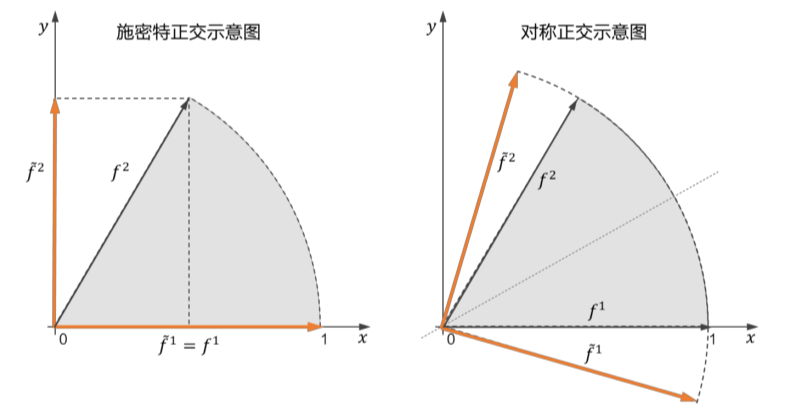
从图中可以看出，施密特正交中排序越高的因子旋转角度越大，对因子并没有平等对待；而对称正交中因子都各自旋转了同样很小的角度来得到正交基，对因子平等对待，且正交前后因子的对应关系保持的很好。

现在知道对称正交的优势了吧 ,下面来看看该方法具体的过渡矩阵时如何计算的：
我们定义一个从$F_{N*K}$旋转到$\widetilde{F_{N*K}} $的`过渡矩阵`$S_{K*K}$，公式如下所示：  

$$S_{K*K}=U_{K*K}D_{K*K}^{-1/2}U_{K*K}^{'}$$

其中，记矩阵$M=F_{N*K}^{'}F_{N*K} $,$D_{K*K}$为M的特征根构成的对角阵，$U_{K*K}$为每一列由M的特征向量构成的矩阵。$S_{K*K}$是一个对角矩阵，所以我们才称之为对称正交,$F_{N*K}$的旋转公式如下：

$$\widetilde{F_{N*K}} =F_{N*K}S_{K*K}$$

In [8]:
## step5:构建对称正交变换函数
def lowdin_orthogonal(data:pd.DataFrame)->pd.DataFrame:

    data_ = data.copy() # 创建副本不影响原数据
    col = [col for col in data_.columns if col not in ['INDUSTRY_CODE','market_cap']]
    
    F = np.mat(data_[col])  # 除去行业指标,将数据框转化为矩阵
    M = F.T @ F # 等价于 (F.shape[0] - 1) * np.cov(F.T)
    a,U = np.linalg.eig(M)  # a为特征值，U为特征向量
    D_inv = np.linalg.inv(np.diag(a))
    S = U @ np.sqrt(D_inv) @ U.T
    data_[col] = data_[col].dot(S)
    
    return data_

In [14]:
# 数据读取
factors4 = pd.read_csv('factors4.csv',index_col=[0,1],parse_dates=[0],dtype={'INDUSTRY_CODE':str})

#对称正交化
factors5 = factors4.groupby(level='date').apply(lowdin_orthogonal)  
factors5.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 37365 entries, (2010-01-29 00:00:00, 000001.XSHE) to (2020-09-30 00:00:00, 603993.XSHG)
Data columns (total 22 columns):
NATURAL_LOG_OF_MARKET_CAP        37365 non-null float64
ROE_TTM                          37365 non-null float64
ROC60                            37365 non-null float64
TOTAL_PROFIT_GROWTH_RATE         37365 non-null float64
BOOK_TO_PRICE_RATIO              37365 non-null float64
VOL60                            37365 non-null float64
NET_PROFIT_GROWTH_RATE           37365 non-null float64
OPERATING_REVENUE_GROWTH_RATE    37365 non-null float64
ROA_TTM                          37365 non-null float64
VOL20                            37365 non-null float64
ROC20                            37365 non-null float64
EPTTM                            37365 non-null float64
SPTTM                            37365 non-null float64
SUE0                             37365 non-null float64
SUR0                             37365 non-nu

In [11]:
#构建计算横截面因子载荷相关系数均值函数
def get_relations(datas: pd.DataFrame) -> pd.DataFrame:

    relations = 0
    for trade,d in datas.groupby(level='date'):
        
        relations += d.corr()

    relations_mean = relations / len(datas.index.levels[0])

    return relations_mean

未进行正交处理,各因子的相关性如下

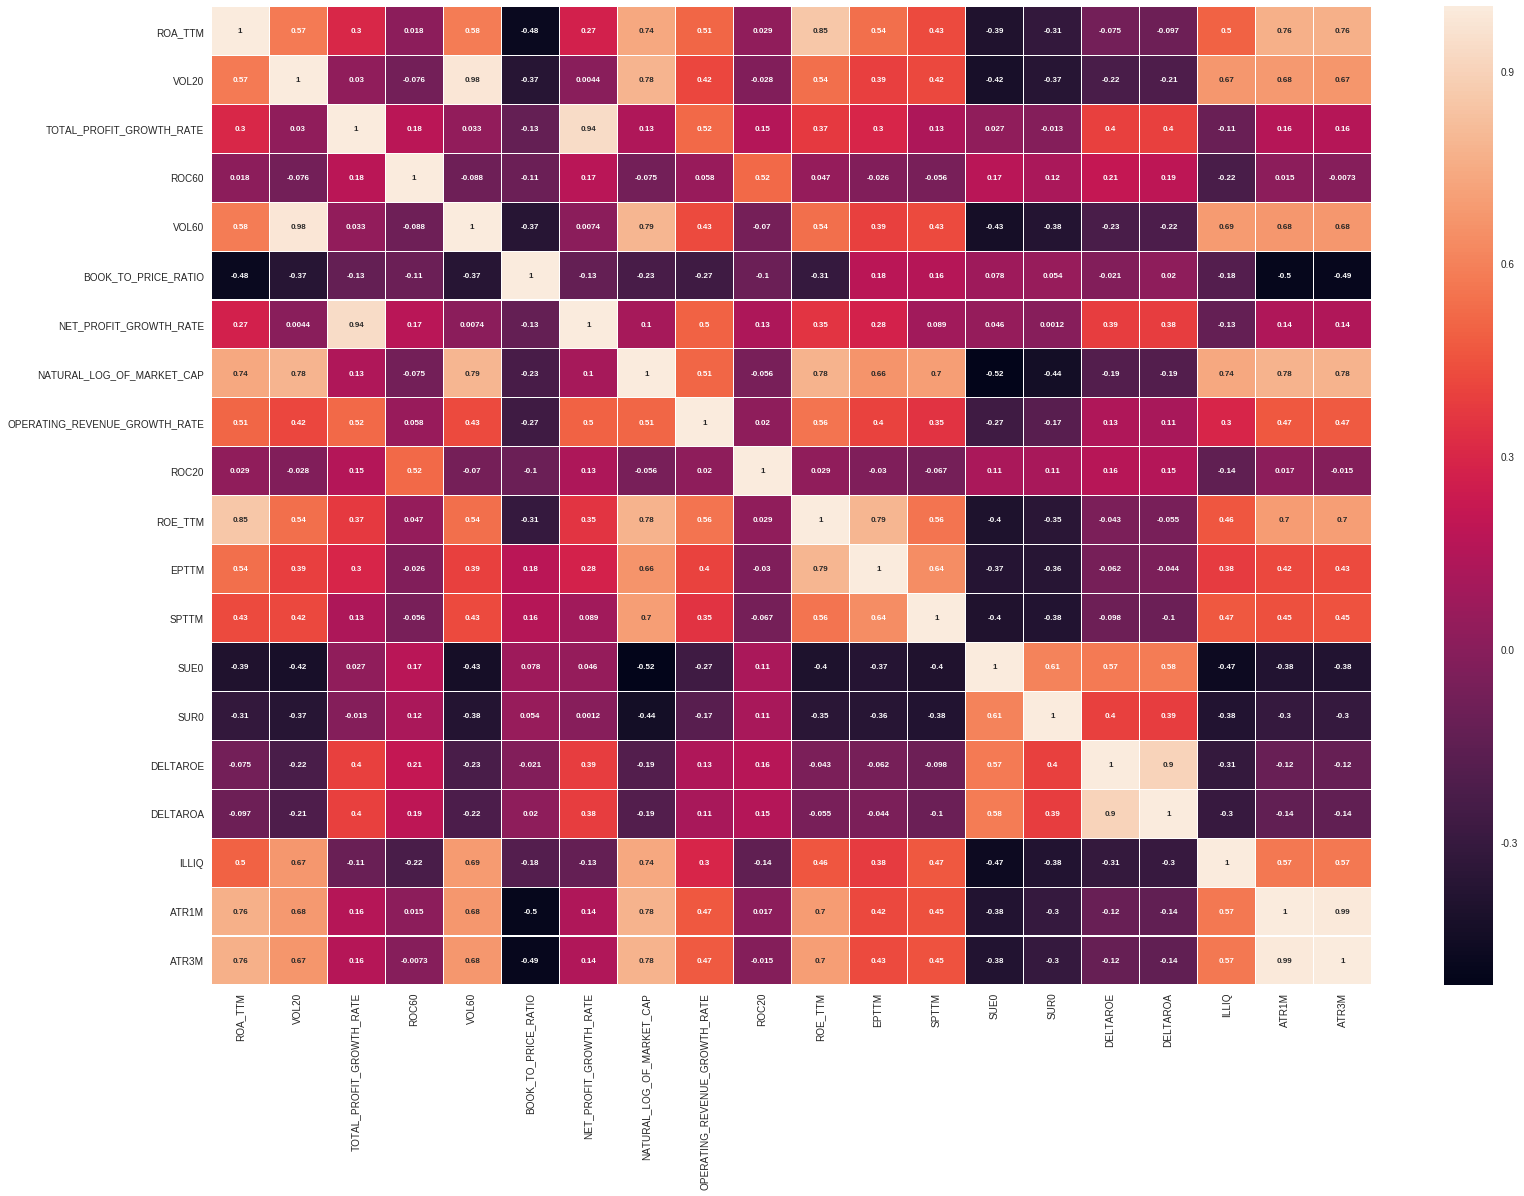

In [76]:
# 绘制因子正交前的相关性的热力图
fig = plt.figure(figsize=(26, 18))
# 计算对称正交之前的相关系数矩阵
relations = get_relations(factors4.iloc[:,:-2])  
sns.heatmap(relations, annot=True, linewidths=0.05,
            linecolor='white', annot_kws={'size': 8, 'weight': 'bold'})

正交处理后各因子相关性明显下降

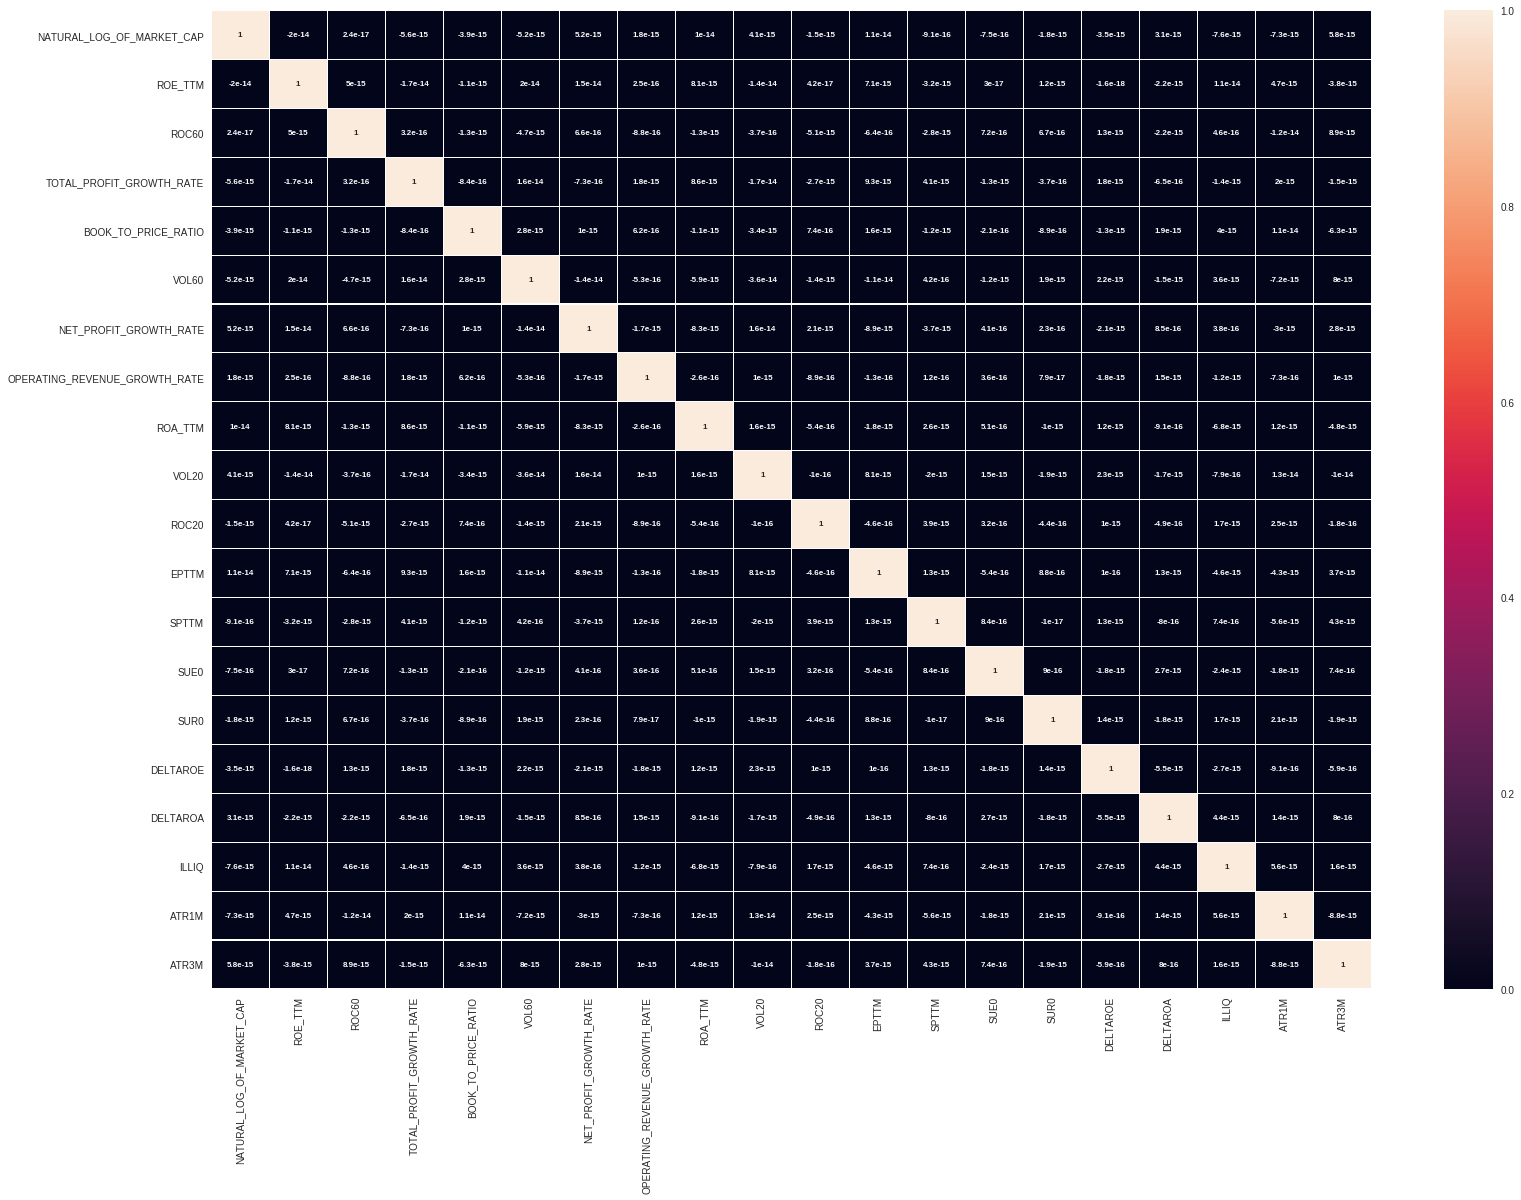

In [12]:
#绘制因子正交后的相关性热力图
fig=plt.figure(figsize=(26,18))
#计算对称正交之后的相关系数矩阵
relations= get_relations(factors5.iloc[:,:-2])  
sns.heatmap(relations,annot=True,linewidths=0.05,
            linecolor='white',annot_kws={'size':8,'weight':'bold'})

## 五、打分法计算预期收益

### 5.1计算ICIR权重

在利用IR加权法计算权重时，各因子权重值为各因子在滚动时间内平均IR值在所有因子在滚动时间内平均IR值之和中的占比，因子在滚动时间内平均IR值越大，说明该因子在选股时作用越大，权重也越大，反之亦然。在利用IR计算权重时需注意的是：在滚动计算IC序列标准差时，起始日期得到的是缺失值，所以对于起始日期的IR值我们用该时点的IC值来代替， 得到的权重也为IC值计算的IC权重。

In [15]:
def get_next_ret(factor: pd.DataFrame, keep_last_term: bool = False, last_term_next_date: str = None) -> pd.Series:
    '''
    keep_last_term:是否保留最后一期数据
    last_term_next_date:如果keep_last_term=True,则此参数为计算最后一期下期收益时的截止时间,必须时交易日
    '''

    securities = factor.index.levels[1].tolist()  # 股票代码
    periods = [i.strftime('%Y-%m-%d') for i in factor.index.levels[0]]  # 日期

    if keep_last_term:
        end = last_term_next_date
        periods = periods + [end]

        if not end:
            raise ValueError('如果keep_last_term=True,则必须有last_term_next_date参数')

    close = pd.concat([get_price(securities, end_date=i, count=1, fields='close', panel=False)
                       for i in periods])

    close = pd.pivot_table(close, index='time', columns='code', values='close')
    ret = close.pct_change().shift(-1)
    ret = ret.iloc[:-1]
    return ret.stack()

In [16]:
# 获取下期收益率
next_ret = get_next_ret(factors5,True,'2020-10-14')

factors5['NEXT_RET'] = next_ret

In [19]:
# 根据IR计算因子权重

# step1:计算rank_IC


def calc_rank_IC(factor: pd.DataFrame) -> pd.DataFrame:

    factor_col = [x for x in factor.columns if x not in [
        'INDUSTRY_CODE', 'market_cap', 'NEXT_RET']]

    IC = factor.groupby(level='date').apply(lambda x: [st.spearmanr(
        x[factor], x['NEXT_RET'])[0] for factor in factor_col])
    
    return pd.DataFrame(IC.tolist(), index=IC.index, columns=factor_col)


## step2: 计算IR权重
def IR_weight(factor: pd.DataFrame) -> pd.DataFrame:

    data_ = factor.copy()
    # 计算ic值，得到ic的
    IC = calc_rank_IC(data_)
    
    # 计算ic的绝对值
    abs_IC = IC.abs()
    # rolling为移动窗口函数,滚动12个月
    rolling_ic = abs_IC.rolling(12, min_periods=1).mean()
    # 当滚动计算标准差时，起始日期得到的是缺失值，所以算完权重后，起始日期的值任用原值IC代替
    rolling_ic_std = abs_IC.rolling(12, min_periods=1).std()
    IR = rolling_ic / rolling_ic_std  # 计算IR值
    IR.iloc[0,:] = rolling_ic.iloc[0,:]
    weight = IR.div(IR.sum(axis=1), axis=0)  # 计算IR权重,按行求和,按列相除

    return weight

In [20]:
# 获取权重
weights = IR_weight(factors5)

In [21]:
# 获取因子名称
factor_names = [name for name in factors5.columns if name not in [
    'INDUSTRY_CODE', 'market_cap', 'NEXT_RET']]

# 计算因子分数
factors5['SCORE'] = (factors5[factor_names].mul(weights)).sum(axis=1)

In [22]:
# 数据储存
factors5.to_csv('factors5.csv')

In [23]:
factors5.head()

NATURAL_LOG_OF_MARKET_CAP    ...        SCORE
date       code                                      ...             
2010-01-29 000001.XSHE                  -0.025422    ...    -0.011532
           000002.XSHE                  -0.077438    ...    -0.007426
           000009.XSHE                   0.008981    ...     0.000890
           000012.XSHE                  -0.009324    ...     0.015042
           000021.XSHE                   0.032012    ...    -0.009551

[5 rows x 24 columns]

# 六、分层抽样指数增强策略实现

## 6.1 策略概述

市值和行业是很重要的风险因子，分层抽样策略的核心是使投资组合在这两个风险维度上与基准指数保持一致，然后在市值、行业属性比较相似的若干只股票里优选一只预期收益最高的进行投资，以获取超额收益。  

策略中所使用的`行业分类`如下：
以申万34个一级行业为蓝本

`策略步骤`：  
**step1**:将基准指数成份股按以上行业划分成34个子集，在每个子集中用市值因子将股票划分为数目相等的三组；  
**step2**:计算每个小组内所有股票在基准指数中的总权重；  
**step3**:在每个小组中选择预期收益（打分法）最高的一只股票，令它在投资组合中的权重等于它所处小组的权重。这样就能选出包含102只股票的分层抽样组合。

**本策略的基准指数选`沪深300指数`，且在基准指数`成份股内`选股。**

+ 参考于华泰证券《指数增强方法汇总及实例——量化多因子指数增强策略实证》中的第一个简单策略。

In [4]:
def get_weighs(symbol:str,start:str,end:str,method:str='cons')->pd.DataFrame:
    '''
    获取月度指数成份权重
    --------
        mehtod:ind 输出 行业权重
               cons 输出 成份股权重
    '''
    periods = GetTradePeriod(start, end, 'ME')
    
    ser_dic = {}
    if method == 'ind':
        for d in periods:

            # 获取当日成份及权重
            index_w = get_index_weights(symbol,date=d)
            # 获取行业
            index_w['ind'] = get_stock_ind(index_w.index.tolist(),d)
            # 计算行业所占权重
            weight = index_w.groupby('ind')['weight'].sum() / 100

            ser_dic[d] = weight

        ser = pd.concat(ser_dic,names=['date','industry']).reset_index()
        ser['date'] = pd.to_datetime(ser['date'])
        return ser.set_index(['date','industry'])
    
    elif method == 'cons':
        
        df = pd.concat([get_index_weights(symbol,date = d) for d in periods])
        df.drop(columns='display_name',inplace=True)
        
        df.set_index('date',append=True,inplace=True)
        df = df.swaplevel()
        df['weight'] = df['weight'] / 100
        return df
            


def get_group(ser:pd.Series,N:int=3,ascend:bool=True)->pd.Series:
    '''默认分三组 升序'''
    ranks = ser.rank(ascending=ascend)
    label = ['G'+str(i) for i in range(1,N + 1)]
    
    return pd.cut(ranks,bins= N,labels=label) 


In [5]:
# 数据读取
factors5 = pd.read_csv('factors5.csv',index_col=[0,1],parse_dates=[0],dtype={'INDUSTRY_CODE':str})
factors5.tail()

NATURAL_LOG_OF_MARKET_CAP    ...        SCORE
date       code                                      ...             
2020-09-30 603799.XSHG                  -0.030456    ...    -0.010918
           603833.XSHG                   0.035622    ...     0.019785
           603899.XSHG                   0.002282    ...     0.015803
           603986.XSHG                   0.027773    ...    -0.006480
           603993.XSHG                  -0.051922    ...    -0.026097

[5 rows x 24 columns]

In [54]:
def stratified_sampling(symbol: str, START_DATE: str, END_DATE: str, factors: pd.DataFrame) -> pd.DataFrame:
    
    factors_ = factors.copy()
    ind_weight = get_weighs(symbol, START_DATE, END_DATE)

    # 市值等量分三组
    k1 = [pd.Grouper(level='date'),
          pd.Grouper(key='INDUSTRY_CODE')]

    factors_['GROUP'] = factors_.groupby(
        k1)['market_cap'].apply(lambda x: get_group(x, 3))

    # 获取每组得分最大的
    k2 = [pd.Grouper(level='date'),
          pd.Grouper(key='INDUSTRY_CODE'),
          pd.Grouper(key='GROUP')]

    industry_kfold_stock = factors_.groupby(
        k2)['SCORE'].apply(lambda x: x.idxmax()[1])
    
    # 格式调整
    industry_kfold_stock = industry_kfold_stock.reset_index()
    industry_kfold_stock = industry_kfold_stock.set_index(['date', 'SCORE'])
    industry_kfold_stock.index.names = ['date', 'code']
    
    # 加入权重
    industry_kfold_stock['weight'] = ind_weight['weight']
    
    # 令权重加总为1
    industry_kfold_stock['w'] = industry_kfold_stock.groupby(
        level='date')['weight'].transform(lambda x: x / x.sum())
    
    industry_kfold_stock['NEXT_RET'] = factors['NEXT_RET']

    return industry_kfold_stock

In [55]:
# 获取分层数据
result_df = stratified_sampling('000300.XSHG', START_DATE, END_DATE, factors5[[
                                'INDUSTRY_CODE', 'market_cap', 'SCORE', 'NEXT_RET']])

In [35]:
# 储存,用于回测
result_df.to_csv('../../result_df.csv')
result_df.head()

INDUSTRY_CODE GROUP  weight         w  NEXT_RET
date       code                                                       
2010-01-29 600816.XSHG        801190    G1  0.0011  0.005726  0.053279
           000783.XSHE        801190    G2  0.0045  0.023425 -0.004335
           601601.XSHG        801190    G3  0.0135  0.070276  0.074182
           600638.XSHG        801180    G1  0.0013  0.006767  0.034389
           600675.XSHG        801180    G2  0.0020  0.010411  0.026132

In [22]:
# 根据result_df文件中生成的权重及股票名单进行回测
# 获取回测结果
gt = get_backtest('b5f5173d64f8fb49496c2c309c0635e3')

algorithm = pd.DataFrame(gt.get_results()).set_index('time')
algorithm['excess_returns'] = (
    algorithm['returns'] + 1) / (algorithm['benchmark_returns'] + 1) - 1

algorithm.index = pd.to_datetime(algorithm.index)
algorithm.head()

,benchmark_returns,returns,excess_returns
time,,,
2010-01-04 16:00:00,-0.011313,0.0,0.011442
2010-01-05 16:00:00,-0.003255,0.0,0.003266
2010-01-06 16:00:00,-0.009495,0.0,0.009586
2010-01-07 16:00:00,-0.029147,0.0,0.030022
2010-01-08 16:00:00,-0.026722,0.0,0.027456


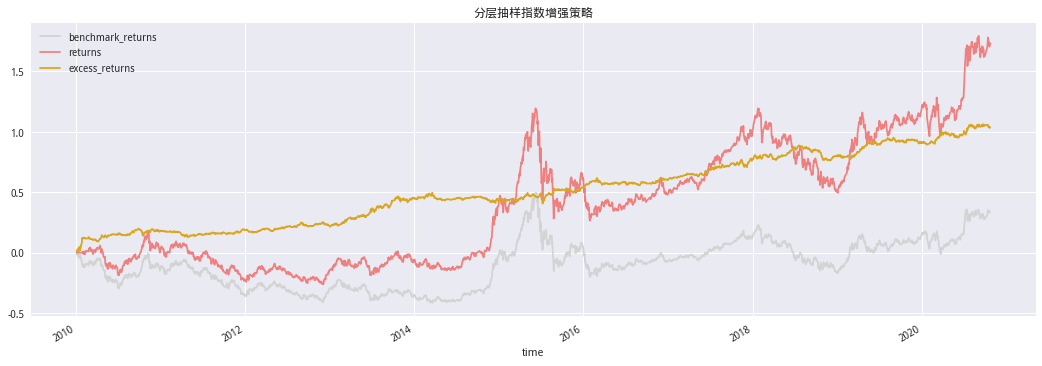

In [24]:
plt.rcParams['font.family'] = 'serif'
algorithm.plot.line(figsize=(18, 6), title='分层抽样指数增强策略', color=[
                    'LightGrey', 'LightCoral', 'GoldenRod'])

In [25]:
# 风险指标如下
pd.Series(gt.get_risk()).iloc[1:]

algorithm_return                                      1.72765
algorithm_volatility                                 0.232204
alpha                                               0.0717342
annual_algo_return                                   0.100361
annual_bm_return                                    0.0283163
avg_excess_return                                  0.00027744
avg_position_days                                     293.056
avg_trade_return                                    0.0395027
benchmark_return                                     0.340397
benchmark_volatility                                 0.231306
beta                                                 0.973403
day_win_ratio                                        0.531834
excess_return                                         1.03495
excess_return_max_drawdown                          0.0662488
excess_return_max_drawdown_period    [2018-07-19, 2018-11-27]
excess_return_sharpe                                 0.525077
informat

# 七、多因子线性优化模型指数增强策略实现

## 7.1 策略概述
`多因子线性优化模型指数增强策略`的核心是控制投资组合在更多的风险因子上的暴露与基准指数一致，以期获得更小的跟踪误差。常见的风险控制形式主要包括风险暴露约束、行业暴露约束、相对于基准跟踪误差约束、个股权重约束等，这些约束条件都能有效地控制组合相对基准指数的偏离，使组合能稳定的战胜基准指数。该策略一般需要通过求解二次优化或非线性优化问题来构建最优组合。

策略的组合优化模型形式如下所示：  

目标函数：$$max( r^{T}w)$$
约束条件：$$s_{l}\leqslant X(w-w_{b})\leqslant s_{h}$$

$$h_{l}\leqslant H(w-w_{b})\leqslant h_{h}$$

$$w_{l}\leqslant w-w_{b} \leqslant w_{h}$$

$$b_{l}\leqslant B_{b}w \leqslant b_{h}$$

$$0 \leqslant w \leqslant l $$

$$I^{T}w=1$$

该优化问题的目标函数为最大化组合收益，其中$r^{T}w$为组合预期收益，w为待求解的股票权重向量，r为前面计算得到的每股综合得分。模型的约束条件包括在风格因子上的偏离度、行业偏离度、个股偏离度、成分股权重占比控制、个股权重上限控制，具体解释如下：  

+ 约束条件1控制了组合相对于基准指数的风格暴露，X为股票对风格因子的因子暴露矩阵，$w_{b}$为基准指数成分股的权重向量，$s_{l},s_{h}$分别为风格因子相对暴露的下限和上限；


+ 约束条件2限制了组合相对于基准指数的行业偏离，H为股票的行业暴露矩阵，当股票i属于行业j时，$H_{ji}$为1，否则为0，$h_{l},h_{h}$分别为组合行业偏离的下限和上限，此处行业采用前文的32个行业分类方法；


+ 约束条件3限制了个股相对于基准指数成分股的偏离，$w_{l},w_{h}$分别为个股偏离的下限和上限；


+ 约束条件4限制了组合在成分股内权重的占比下限及上限，$B_{b}$为个股是否属于基准指数成分股的0-1向量，$b_{l},b_{h}$分别为成分股内权重占比的上限及下限；


+ 约束条件5限制了卖空，并且限制了个股权限的上限l；


+ 约束条件6要求权重和为1，即组合始终满仓运作。

`注：`该组合优化模型没有采用二次项的跟踪误差约束（$\left ( w-w_{b} \right )^{T}\Sigma \left ( w-w_{b} \right )\leqslant \frac{TE^{2}}{250}$,$TE^{2}$为组合的预期年化跟踪误差的上限）来控制组合对基准的偏离，而是用的约束条件3中的个股相对于基准指数成分股的偏离度，原因是：  
1、直接用跟踪误差作为约束条件进行风险控制需要估计协方差矩阵，跟踪误差是否控制成功依赖于协方差矩阵估计的准确性，而协方差矩阵的估计本身受很多假设条件的限制，估计较为困难，不稳定性较大，而用个股相对于基准指数成分股的偏离度来控制跟踪误差更为直接，个股偏离度越小，对基准指数的跟踪误差也就越小；  
2、跟踪误差约束是二次约束，而偏离度约束是线性约束，后者比前者的求解更高效。

***本策略的基准指数选`沪深300指数`，且在基准指数成份股内选股，所以约束条件4不用设置。***

+ 参考：天风证券《基于自适应风险控制的指数增强策略》中的静态指数增强策略

In [61]:
def get_optimization_weight(df: pd.DataFrame):
    '''
    权重优化
    '''
    df_ = df.copy()
    index_weight = df_['weight'].values
    score = df_['SCORE'].values
    f = df_.drop(columns=['SCORE', 'weight']).T.values

    length = len(df_)
    
    # 目标函数
    def func(w): return - w.dot(score)

    # 1.构建约束条件1和2的不等式右边
    # 2.构建约束条件1和2的不等式左边
    # 3.构建约束条件3个股相对于基准指数成分股的偏离，最多不超过0.5%，不等式右
    # 4.构建约束条件6组合权重之和为1
    cons = (
        {'type': 'ineq', 'fun': lambda w: 1.05 *
            f.dot(index_weight) - f.dot(w)},
        {'type': 'ineq', 'fun': lambda w: f.dot(
            w) - 0.95 * f.dot(index_weight)},
        {'type': 'ineq', 'fun': lambda w: 0.05 *
         np.ones(length) - (w - index_weight)},
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    )

    # 建立约束条件5，个股权重上限，及权重的取值范围
    limit = tuple((0, 1.5) for x in range(length))
    
    # 确定初始权重，为等权重
    w0 = index_weight  
    
    # 利用递归最小二乘求解最优权重
    res = minimize(func, w0, method='SLSQP', bounds=limit,
                   constraints=cons)  
    
    if res['success'] != True:
        print(df.name)

    return pd.Series(res['x'], index=df_.index.get_level_values(1))

In [33]:
from scipy.optimize import NonlinearConstraint
def get_optimization_weight(df: pd.DataFrame):
    '''
    权重优化
    '''
    df_ = df.copy()
    index_weight = df_['weight'].values
    score = df_['SCORE'].values
    f = df_.drop(columns=['SCORE', 'weight']).T.values

    length = len(df_)
    
    # 目标函数
    func = lambda w: - w.dot(score)

    # 约束条件1,2
    cons_1 = lambda w:f @ (index_weight -  w)
    
    # 约束条件3:个股相对于基准指数成分股的偏离
    cons_2 = lambda w:w - index_weight
    
    # 约束条件6:权重之和为1
    cons_3 = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    
    nonlinear_constraint1 = NonlinearConstraint(cons_1,0.95,1.05)
    nonlinear_constraint2 = NonlinearConstraint(cons_2,0.,0.05)
    
    # 建立约束条件5，个股权重上限，及权重的取值范围
    limit = tuple((0, 1.5) for x in range(length))

    # 利用递归最小二乘求解最优权重
    res = minimize(func, index_weight, method='SLSQP', bounds=limit,
                   constraints=[nonlinear_constraint1,nonlinear_constraint2,cons_3])  
    
    if res['success'] != True:
        print(df.name)

    return pd.Series(res['x'], index=df_.index.get_level_values(1))

In [6]:
slice_df = factors5.loc['2010-01-29'].copy()

slice_df['weight'] = get_index_weights(
    '000300.XSHG', '2010-01-29').set_index('date', append=True).swaplevel()['weight']

select_col = [col for col in slice_df.columns if col not in ['market_cap','NEXT_RET']]

df = pd.get_dummies(slice_df[select_col],columns=['INDUSTRY_CODE'])
    
index_weight = df['weight'].values
score = df['SCORE'].values
f = df.drop(columns=['SCORE', 'weight']).T.values

length = len(df)

In [13]:
def optimization_result(symbol:str,start:str,end:str,factors:pd.DataFrame)->pd.DataFrame:
    '''
    获取优化权重后的结果
    '''
    factors = factors.copy()
    ind_weight = get_weighs(symbol, start, end)
    factors['weight'] = ind_weight['weight']


    index_weight = factors['weight'].values
    select_col = [col for col in factors.columns if col not in ['market_cap','NEXT_RET']]

    df = pd.get_dummies(factors[select_col],columns=['INDUSTRY_CODE'])
    
    result_df = df.groupby(level='date').apply(get_optimization_weight)
    
    return result_df.to_frame('w')

可以看到大部分日期没有计算得到最优解,但迭代计算的结果也会优于原始权重

In [28]:
result1_df = optimization_result('000300.XSHG',START_DATE,END_DATE,factors5)

2010-01-29 00:00:00
2010-02-26 00:00:00
2010-03-31 00:00:00
2010-04-30 00:00:00
2010-05-31 00:00:00
2010-06-30 00:00:00
2010-07-30 00:00:00
2010-08-31 00:00:00
2010-09-30 00:00:00
2010-10-29 00:00:00
2010-11-30 00:00:00
2010-12-31 00:00:00
2011-01-31 00:00:00
2011-02-28 00:00:00
2011-03-31 00:00:00
2011-04-29 00:00:00
2011-05-31 00:00:00
2011-06-30 00:00:00
2011-07-29 00:00:00
2011-08-31 00:00:00
2011-09-30 00:00:00
2011-10-31 00:00:00
2011-11-30 00:00:00
2011-12-30 00:00:00
2012-01-31 00:00:00
2012-02-29 00:00:00
2012-03-30 00:00:00
2012-04-27 00:00:00
2012-05-31 00:00:00
2012-06-29 00:00:00
2012-07-31 00:00:00
2012-08-31 00:00:00
2012-09-28 00:00:00
2012-10-31 00:00:00
2012-11-30 00:00:00
2012-12-31 00:00:00
2013-01-31 00:00:00
2013-02-28 00:00:00
2013-03-29 00:00:00
2013-04-26 00:00:00
2013-05-31 00:00:00
2013-06-28 00:00:00
2013-07-31 00:00:00
2013-08-30 00:00:00
2013-09-30 00:00:00
2013-10-31 00:00:00
2013-11-29 00:00:00
2013-12-31 00:00:00
2014-01-30 00:00:00
2014-02-28 00:00:00


In [29]:
# 储存结构用于回测
result1_df.to_csv('../../result1_df.csv')
result1_df.head()

w
date       code               
2010-01-29 000001.XSHE  0.0131
           000002.XSHE  0.0176
           000009.XSHE  0.0022
           000012.XSHE  0.0016
           000021.XSHE  0.0011

In [14]:
# 根据result_df文件中生成的权重及股票名单进行回测
# 获取回测结果
gt = get_backtest('477d928643e935c2cdc18f24bed2c9c0')

algorithm = pd.DataFrame(gt.get_results()).set_index('time')
algorithm['excess_returns'] = (
    algorithm['returns'] + 1) / (algorithm['benchmark_returns'] + 1) - 1

algorithm.index = pd.to_datetime(algorithm.index)
algorithm.head()

,benchmark_returns,returns,excess_returns
time,,,
2010-01-04 16:00:00,-0.011313,0.0,0.011442
2010-01-05 16:00:00,-0.003255,0.0,0.003266
2010-01-06 16:00:00,-0.009495,0.0,0.009586
2010-01-07 16:00:00,-0.029147,0.0,0.030022
2010-01-08 16:00:00,-0.026722,0.0,0.027456


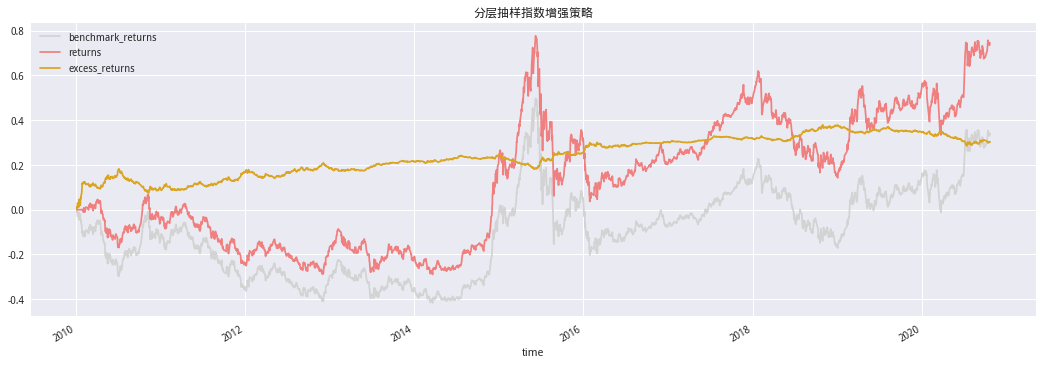

In [20]:
plt.rcParams['font.family'] = 'serif'
algorithm.plot.line(figsize=(18, 6), title='分层抽样指数增强策略', color=[
                    'LightGrey', 'LightCoral', 'GoldenRod'])

In [21]:
# 风险指标如下
pd.Series(gt.get_risk()).iloc[1:]

algorithm_return                                     0.745218
algorithm_volatility                                 0.207377
alpha                                               0.0248952
annual_algo_return                                  0.0545104
annual_bm_return                                    0.0283163
avg_excess_return                                 0.000103468
avg_position_days                                     1105.51
avg_trade_return                                     0.121754
benchmark_return                                     0.340397
benchmark_volatility                                 0.231306
beta                                                 0.888823
day_win_ratio                                        0.495616
excess_return                                        0.302016
excess_return_max_drawdown                          0.0905644
excess_return_max_drawdown_period    [2010-07-05, 2010-11-10]
excess_return_sharpe                                -0.383973
informat